# Analyzing Data with Spark


### Students:
- Kawtar LAGHDAF
- Tijana NINKOVIC

### About the dataset
In this assignment we performed different kinds of analysis on a large dataset using Apache Spark. The data that we studied has been made available by Google and it includes data about a cluster of 12500 machines and the activity on this cluster during 29 days. The data is stored in CSV files and it is organized in the following tables:
* Machine events
* Machine attributes
* Job events
* Task evens
* Task constraints
* Task usage

First, we import the neccessary libraries. We localize Spark package using the function `findspark.find()`, we define the entry to Spark functionality with `SparkContext` and we start a Spark session.
<br>We also import libraries for visualizing data. The main library for visualizing data in Python is `matplotlib`. It is powerful enough to allow us to make any kind of graph we would like. Because it is so powerful, it is also very complex, so another library that was developed on top of it is `seaborn`. The graphs in seaborn look nicer than the ones in matplotlib and it also allows us to make complex visualizations more simple and quick. We will be using both of them.

In [1]:
import sys
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()
from pyspark import SparkContext
import time
from operator import add
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
sc = SparkContext("local[1]")
sc.setLogLevel("ERROR")

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession(sc)

We load the schema file using the `pandas` function `read_csv()` in order to see how the dataset is organized.

In [5]:
schema = pd.read_csv('clusterdata-2011-2/schema.csv')
schema.head()

,file pattern,field number,content,format,mandatory
0,job_events/part-?????-of-?????.csv.gz,1,time,INTEGER,YES
1,job_events/part-?????-of-?????.csv.gz,2,missing info,INTEGER,NO
2,job_events/part-?????-of-?????.csv.gz,3,job ID,INTEGER,YES
3,job_events/part-?????-of-?????.csv.gz,4,event type,INTEGER,YES
4,job_events/part-?????-of-?????.csv.gz,5,user,STRING_HASH,NO


#### The distribution of the machines according to their CPU and memory capacity
For this analysis we used the table **Machine events** which has the following fields:
   1. timestamp
   2. machine ID
   3. event type
   4. platform ID
   5. capacity: CPU
   6. capacity: memory

We load the dataset and define the header, since there is no header in the CSV file.

In [5]:
machine_events_header = ["timestamp", "machine_ID", "event_type", "platform_ID", "capacity_CPU", "capacity_memory"]
machine_events = pd.read_csv('clusterdata-2011-2/machine_events/part-00000-of-00001.csv.gz',
                            names = machine_events_header )
machine_events.head()

,timestamp,machine_ID,event_type,platform_ID,capacity_CPU,capacity_memory
0,0,5,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
1,0,6,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
2,0,7,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
3,0,10,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
4,0,13,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493


We define the function `findCol()` which returns the index of the column name that was passed to it.

In [6]:
def findCol(firstLine, name):
    if name in firstLine:
        return firstLine.index(name)
    else:
        return -1

The way we found the distribution of machines according to CPU capacity is first by creating a new RDD with the dsitinct machine ID and CPU capacity pairs. The reason we call the distinct() function is because this is a table of machine events, meaning that every time a machine is added, removed or updated there is a new row in the dataset, but if it's the same machine all other values in the row will be identical. Therefore, we would have duplicated in our new RDD if there was more than one event on a specific machine.
<br>We then call the `map()` function to map value one to CPU capacity for each row and `reduceByKey()` which adds all those rows and counts how many times each CPU capacity appears in our data. This can be done because CPU capacity is devided into categories: 0.25, 0.5, 0.75 and 1 (one corresponding to the highest capacity). What we are doing here is counting how many machines belong to each of the categories and printing the results.

In [7]:
machine_events = sc.textFile("clusterdata-2011-2/machine_events/*.csv.gz").map(lambda line: line.split(','))
machine_events_header = ["timestamp", "machine_ID", "event_type", "platform_ID", "capacity_CPU", "capacity_memory"]

machine_index = findCol(machine_events_header, "machine_ID")
CPU_index = findCol(machine_events_header, "capacity_CPU")

gpu_data = machine_events.map(lambda x: (x[machine_index],x[CPU_index])).distinct()
gpu_capacity = gpu_data.map(lambda x: (x[1], 1))

gpu_capacity_count = gpu_capacity.reduceByKey(add)
total = gpu_capacity.count()

gpu_capacity_distribution = gpu_capacity_count.map(lambda x: (x[0], x[1]/total*100))

print('The distribution of machines according to their CPU capacity is:')
gpu_capacity_distribution.collect()


The distribution of machines according to their CPU capacity is:


[('0.5', 92.42172017439556),
 ('0.25', 0.9988109393579072),
 ('1', 6.325802615933412),
 ('', 0.2536662703131193)]

Similarly, we can do the same thing for memory capacity. In this case we have more categories than we did for CPU, but still a small enough number to use the same method.

In [8]:
memory_index = findCol(machine_events_header, "capacity_memory")
memory_data = machine_events.map(lambda x: (x[machine_index],x[memory_index])).distinct()
memory_capacity = memory_data.map(lambda x: (x[1], 1))
memory_capacity_count = memory_capacity.reduceByKey(add)

memory_distribution = memory_capacity_count.map(lambda x: (x[0], x[1]))
memory_distribution.collect()

[('0.2493', 3866),
 ('0.4995', 6732),
 ('0.1241', 54),
 ('0.03085', 5),
 ('0.749', 1003),
 ('0.9678', 5),
 ('0.2498', 126),
 ('0.06158', 1),
 ('1', 795),
 ('0.5', 3),
 ('', 32)]

Now we can check if there is any dependency between these two values. 

In [8]:
#creating a pandas data frame with machines and their cpu and memory capacities, for easier visualisation
#first converting to dictionaries and then dataframes, because calling toDF on RDDs was not giving good results
help_dict_cpu = gpu_data.collectAsMap()
help_dict_mem = memory_data.collectAsMap()
cpu_df = pd.DataFrame()
cpu_df["machine ID"] = help_dict_cpu.keys()
cpu_df["CPU capacity"] = help_dict_cpu.values()
cpu_df = cpu_df.set_index('machine ID')
mem_df = pd.DataFrame()
mem_df["machine ID"] = help_dict_mem.keys()
mem_df["memory capacity"] = help_dict_mem.values()
mem_df = mem_df.set_index('machine ID')

merged = cpu_df.merge(mem_df, left_index=True, right_index=True)
merged.head()

,CPU capacity,memory capacity
machine ID,,
5,0.5,0.2493
6,0.5,0.2493
7,0.5,0.2493
10,0.5,0.2493
13,0.5,0.2493


Now, we can plot this values. For this we are using the `countplot()` function from the `seaborn` package which draws bars corresponding to the number of machines belonging to each category.

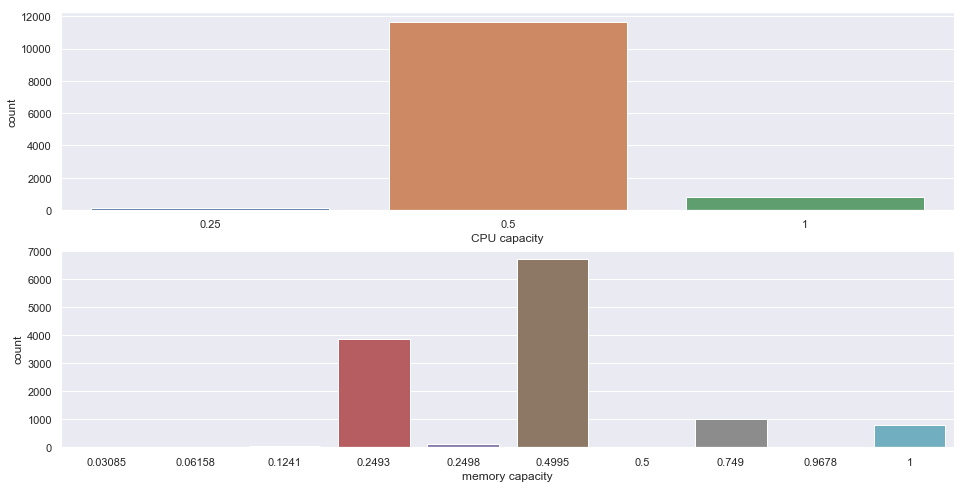

In [11]:
_, axes = plt.subplots(2, 1, figsize=(16, 8))

sns.countplot(x='CPU capacity', data=merged, ax=axes[0])
sns.countplot(x='memory capacity', data=merged, ax=axes[1])

The countplot shows us the distribution of each CPU and memory capacity categories. Both of these values are normalized and take values from 0 to 1, 1 corresponding to the highest CPU/memory capacity from all the machines. For CPU we have different categories and we can see that the majority of machines falls into the '0.5' category.
Memory capacity has more categories, but we still see that the majority of the machines fall in the middle.

In [12]:
pd.crosstab(merged['CPU capacity'], merged['memory capacity'])

memory capacity,0.03085,0.06158,0.1241,0.2493,0.2498,0.4995,0.5,0.749,0.9678,1
CPU capacity,,,,,,,,,,
0.25,0,0,0,0,126,0,0,0,0,0
0.5,5,1,52,3863,0,6732,0,1001,5,0
1,0,0,0,0,0,0,3,0,0,795


`crosstab` gives us values for each CPU/memory pair. From this we observe that machines with the most powerful CPU also have largest memory capacity.

#### The percentage of computational power lost due to maintenance
To compute this we again looked at the **Machine events** table. We first called the `map()` function to create a new RDD that has the machine ID and CPU capacity as the key, and also has the event type and the timestamp at which this event happened. After that, we `groupByKey()` in order to merge these events into a list, so that for each machine we will have a list of events that happened on it. *Event type 1* corresponds to machine being removed and *event type 0* corresponds to machine being added. We use the timestamp to calculate how much time has passed between removing a machine and adding it again and then we multiply that by the CPU capacity of that machine. The sum of all of those values is our *lost capacity.* We also multiply the capacity of each machine with the maximum timestamp that we have in our RDD and assume that would be the *ideal capacity* if machines never went offline. Then, we devide these two numbers to get the *percentage of computational power that was lost*.

In [7]:
machine_events = sc.textFile("clusterdata-2011-2/machine_events/*.csv.gz").map(lambda line: line.split(','))
machine_events_header = ["timestamp", "machine_ID", "event_type", "platform_ID", "capacity_CPU", "capacity_memory"]

eventType_index = findCol(machine_events_header, "event_type")
id_index = findCol(machine_events_header, "machine_ID")
tstmp_index = findCol(machine_events_header, "timestamp")
capacity_index = findCol(machine_events_header, "capacity_CPU")

data = machine_events.map(lambda x: ((x[id_index],x[capacity_index]), (x[eventType_index], x[tstmp_index])))
data = data.groupByKey()

max_time = machine_events.map(lambda x: int(x[tstmp_index])).max()


lost_capacity = 0
ideal_capacity = 0

number_of_machines = data.count()
arr = [] #array in which we will store time that passed between machine being removed and added again

for x in data.take(number_of_machines-100) :
    counter = 0
    events = x[1].data
    capacity = float(x[0][1])
    idx = x[0][0]
    #print("Events machine", idx, "of capacity", capacity, "are", events)
    events.pop(0)
    delta = 0
    while events != []:
        counter = (counter+1)%2
        event = events.pop(0)
        if event[0] == '1':
            delta -= int(event[1])
            time_removed = int(event[1]) #time at which machine was removed
        if event[0] == '0':
            delta += int(event[1])
            time_added = int(event[1]) #time at which machine was added again
            
            diff = time_added - time_removed #time that passed between those two events
            #converting microseconds to seconds and adding to array
            arr.append(diff/1000000)
    if counter == 1:
        delta += max_time
    delta = delta * capacity
    ideal_capacity = ideal_capacity + (max_time * capacity)
    lost_capacity += delta

#Deviding the lost capacity by total capacity that we would have if machines never went offline 
print("The percentage of computational power lost due to maintanance is", round(lost_capacity/ideal_capacity*100, 2), "%")


The percentage of computational power lost due to maintanance is 4.81 %


In the for loop we go through number_of_machines - 100 and not total number of machines. The reason is that when we put just number_of_machines is gives us an error in this line `capacity = float(x[0][1])`. The same error happens if we exclude the last 10 or 50. First we only computed for a fixed number of machines (5000), but then we took 100 as a random number here because when excluding the last 100 everything works fine, but the number is still very small that the machines we are not including would not make a significant change in our final result.

Another thing we can do is plot the distribution of time a machine was offline for maintenance. We found this time as a difference between timestamps of when machine was removed and timestamp of when machine was added again. These timestamps represent microseconds, so we converted them to seconds.

We saved all these values in an array and when observing the results we got, we saw that there are a lot of outliers when machine was offline for significantly longer than average. The function below is used for removing those outliers.

In [8]:
def reject_outliers(data, m=.5):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

np_arr = np.array(arr)
np_arr = reject_outliers(np_arr)

In the graph below we used a violin plot to represent how these times are distributed. The first one is before removing outliers. We can see that most values are concentrated around zero but because of these extreme cases where machines were offline for a long time (which aren't numerous) we don't see that distribution well. Therefore, in the second graph we represent the distribution without those values. Once again we see that the majority is concentrated around zero.
<br>This tells us that when machines go offline for maintenance that time is usually not long and therefore not a lot of capacity is lost, which also corresponds to the result we got above.

D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


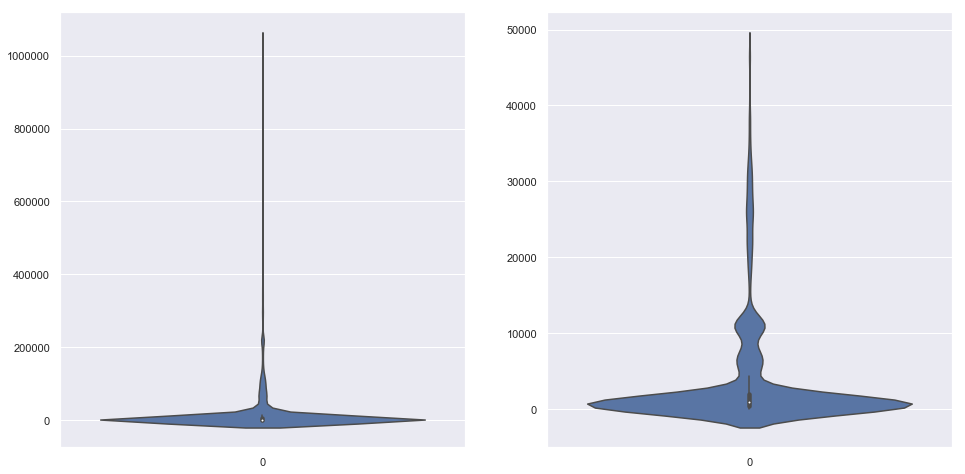

In [9]:
_, axes = plt.subplots(1, 2, sharey=False, figsize=(16, 8))

sns.violinplot(data=arr, ax=axes[0])
sns.violinplot(data=np_arr, ax=axes[1])

#### The distribution of the number jobs/tasks per scheduling class
For this analysis we used the **Task events** table, which has the following fields:
   1. timestamp
   2. missing info
   3. job ID
   4. task index - within the job
   5. machine ID
   6. event type
   7. user name
   8. scheduling class
   9. priority
   10. resource request for CPU cores
   11. resource request for RAM
   12. resource request for local disk space
   13. different-machine constraint

In [13]:
task_events_header = ["timestamp", "missing_info", "job_ID", "task_idx", "machine_ID", "event_type", "user", "scheduling_class", "priority", "rrCPU", "rrRAM", "rrLDS", "diff_machine_constraints"]
task_events = pd.read_csv('clusterdata-2011-2/task_events/part-00000-of-00500.csv.gz',
                            names = task_events_header )

task_events.head()

,timestamp,missing_info,job_ID,task_idx,machine_ID,event_type,user,scheduling_class,priority,rrCPU,rrRAM,rrLDS,diff_machine_constraints
0,0,2.0,3418309,0,4.155527e+09,0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,NaN,NaN,NaN,NaN
1,0,2.0,3418309,1,3.291507e+08,0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,NaN,NaN,NaN,NaN
2,0,NaN,3418314,0,3.938719e+09,0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,0.125,0.07446,0.000424,0.0
3,0,NaN,3418314,1,3.516186e+08,0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,0.125,0.07446,0.000424,0.0
4,0,2.0,3418319,0,4.310529e+08,0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,NaN,NaN,NaN,NaN


First we looked at the distribution of jobs. From the original RDD we create a new one containing only the scheduling class and the job ID. (We call *distinct()* for the same reason as in the previous analysis - there are several events associated with each of these tasks). We call `countByKey()` to count how many different jobs are in each scheduling class (because scheduling class is our key here) and then we just calculate the percentage.

In [15]:
task_events = sc.textFile("clusterdata-2011-2/task_events/part-00000-of-00500.csv.gz").map(lambda line: line.split(','))

job_ID_idx = findCol(task_events_header, "job_ID")
schedul_class_idx = findCol(task_events_header, "scheduling_class")
task_idx = findCol(task_events_header, "task_idx")

#distribution of jobs
data_jobs = task_events.map(lambda x: (x[schedul_class_idx], x[job_ID_idx])).distinct()
data_jobs = data_jobs.countByKey()
total = sum(data_jobs.values())

for x in data_jobs:
    print("Sheduling class", x,"contains",data_jobs[x],"jobs:", data_jobs[x]/total*100, "%")


Sheduling class 3 contains 933 jobs: 19.06026557711951 %
Sheduling class 2 contains 1419 jobs: 28.98876404494382 %
Sheduling class 1 contains 1624 jobs: 33.17671092951992 %
Sheduling class 0 contains 919 jobs: 18.774259448416753 %


Now we do the same thing for tasks. The only thing that changes here is that tasks are identified by both the job ID and task ID, so we need both of those fields in our RDD.

In [16]:
#distribution of tasks
data_tasks = task_events.map(lambda x: (x[schedul_class_idx], (x[task_idx],x[job_ID_idx]))).distinct()
data_tasks = data_tasks.countByKey()
total = sum(data_tasks.values())

for x in data_tasks:
    print("Sheduling class", x,"contains",data_tasks[x],"tasks:", data_tasks[x]/total*100, "%")

Sheduling class 3 contains 28110 tasks: 14.722981678765596 %
Sheduling class 2 contains 41873 tasks: 21.931533683207107 %
Sheduling class 1 contains 26699 tasks: 13.983951897593833 %
Sheduling class 0 contains 94244 tasks: 49.36153274043347 %


Again, for visualization purposes it was easier to make a pandas data frame which will contain the scheduling class and the number of jobs and tasks belonging to that class.

In [17]:
jobs_df = pd.DataFrame()
jobs_df['Scheduling class'] = data_jobs.keys()
jobs_df['Number of jobs'] = data_jobs.values()
tasks_df = pd.DataFrame()
tasks_df['Scheduling class'] = data_tasks.keys()
tasks_df['Number of tasks'] = data_tasks.values()
merged_df = jobs_df.merge(tasks_df)
merged_df

,Scheduling class,Number of jobs,Number of tasks
0,3,933,28110
1,2,1419,41873
2,1,1624,26699
3,0,919,94244


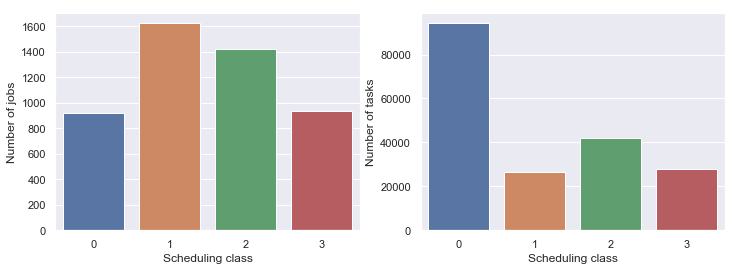

In [26]:
#plotting the number of jobs and tasks in each scheduling class
_, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.barplot('Scheduling class', 'Number of jobs', data=merged_df, ax=axes[0])
sns.barplot('Scheduling class', 'Number of tasks', data=merged_df, ax=axes[1])

From this graph we see that, in terms of jobs, most of them belong to classes 1 and 2 and there are fewer in classes 0 and 3. However, when it comes to tasks, significantly more belong to class 0 than to other three classes.

#### The percentage of tasks that got killed or evicted depending on the scheduling class
The scheduling class roughly represents how latency-sensitive a job is. Class 3 are tasks that are the most latency-sensitive, whereas class 0 are non-production tasks.

For this analysis we are using **Task events** again. The key in our new RDD is the scheduling class, the job ID and the task ID, and the other column we have is the event type. After grouping by key, what we get is a list of all the events associated with each of our keys. *Event type 5* corresponds to a killed task, and *event type 2* corresponds to an evicted task, so we filter those. Then we create a new RDD with just the scheduling class, job ID and task ID, and we do `countByKey()` to get the number of killed/evicted tasks in each scheduling class. We also create a RDD with total number of tasks in each scheduling class.

Next, we go through this RDD and for each scheduling class we devide the *number of killed tasks in that class* with the *total number of tasks in that class*. The reason we are diving by this instead of *total number of killed tasks* (which was our first intuition) is because in that case our results would have been biased. If there are significantly more tasks in one class than the other then the number of killed tasks is likely to be bigger as well. Because of that, we divide by the number of tasks in a given class. With this, we are getting the probability of a task to be killed if it is in a certain class (how many tasks in a given class were killed).

We do the same for evicted tasks. In the end, we just save these numbers to a pandas data frame.

In [24]:
#ditribution of killed/evicted tasks 
task_events_header = ["timestamp", "missing_info", "job_ID", "task_idx", "machine_ID", "event_type", "user", "scheduling_class", "priority", "rrCPU", "rrRAM", "rrLDS", "diff_machine_constraints"]
task_events = sc.textFile("clusterdata-2011-2/task_events/part-00000-of-00500.csv.gz").map(lambda line: line.split(','))

eventType_index = findCol(task_events_header, "event_type")
job_ID_idx = findCol(task_events_header, "job_ID")
task_idx = findCol(task_events_header, "task_idx")
schedul_class_idx = findCol(task_events_header, "scheduling_class")


data = task_events.map(lambda x: ((x[schedul_class_idx], x[job_ID_idx], x[task_idx]), x[eventType_index]))
tasks = data.groupByKey()

killed_tasks = tasks.filter(lambda x: '5' in x[1].data)
evicted_tasks = tasks.filter(lambda x: '2' in x[1].data)

killed_by_class = killed_tasks.map(lambda x: (x[0][0], x[0][1], x[0][2])).countByKey()
evicted_by_class = evicted_tasks.map(lambda x: (x[0][0], x[0][1], x[0][2])).countByKey()
total_by_class = tasks.map(lambda x: (x[0][0], x[0][1], x[0][2])).countByKey()

head = ['Scheduling class', 'killed tasks %', 'evicted tasks %']
table=[]
for x in killed_by_class.keys():
    table.append([x, round(killed_by_class[x]/total_by_class[x]*100,3), round(evicted_by_class[x]/total_by_class[x]*100,3)])

data = np.array(table)
df = pd.DataFrame(data)
df.columns = head
#converting them because they are strings
df["Scheduling class"] = df["Scheduling class"].astype(int)
df["killed tasks %"] = df["killed tasks %"].astype(float)
df["evicted tasks %"] = df["evicted tasks %"].astype(float)
df.head()

,Scheduling class,killed tasks %,evicted tasks %
0,3,0.953,0.064
1,2,0.798,1.163
2,0,5.066,2.881
3,1,0.667,2.637


We used a barplot to visualize these numbers.

<BarContainer object of 4 artists>

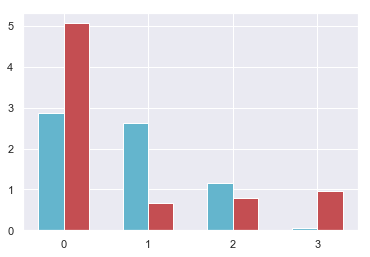

In [25]:
plt.bar(df['Scheduling class'], df['killed tasks %'], label = 'Killed', tick_label = df['Scheduling class'], width=0.3, align='edge', color='r')
plt.bar(df['Scheduling class'], df['evicted tasks %'], label = 'Evicted', tick_label = df['Scheduling class'], width=-0.3, align='edge', color='c')

Looking at this graph or the table above, we can see that the number of tasks that were killed or evicted depends on the scheduling class. 
The x-axis represents different scheduling classes and the y-axis represents the percentage of jobs that were killed or evicted in that scheduling class. Red bars are killed tasks and blue bars are evicted tasks. 

The percentage of killed tasks in scheduling class 0 is significantly bigger than in other classes. For the remaining three the number is similar, below 1%. For evicted tasks we can see that the number in classes 0 and 1 is the biggest and that in class 3 it is very small.

#### Do tasks with low priority have a higher probability of being evicted?
Here we used the **Task events** table again because it also has information about the priority of the tasks. We are doing a similar analysis as before, but instead of using the scheduling class column, we are using the priority column. We again filter the tasks for which we have *event type 2* (which means they were evicted) and then for each priority divide the number of evicted tasks of given priority with the total number of tasks of that priority.
<br>Here we only have information about 5 classes because we are not using all of the files and we are also filtering only the evicted tasks, so some classes get lost after this filtering.

In [32]:
#tasks and their events according to priority 
task_events_header = ["timestamp", "missing_info", "job_ID", "task_idx", "machine_ID", "event_type", "user", "scheduling_class", "priority", "rrCPU", "rrRAM", "rrLDS", "diff_machine_constraints"]
task_events = sc.textFile("clusterdata-2011-2/task_events/part-00000-of-00500.csv.gz").map(lambda line: line.split(','))

eventType_index = findCol(task_events_header, "event_type")
job_ID_idx = findCol(task_events_header, "job_ID")
task_idx = findCol(task_events_header, "task_idx")
priority_idx = findCol(task_events_header, "priority")

data = task_events.map(lambda x: ((x[priority_idx], x[job_ID_idx], x[task_idx]), x[eventType_index])).groupByKey()
evicted_tasks = data.filter(lambda x: '2' in x[1])

evicted_by_priority = evicted_tasks.map(lambda x: (x[0][0], x[0][1], x[0][2])).countByKey()
total_by_priority = data.map(lambda x: (x[0][0], x[0][1], x[0][2])).countByKey()

table=[]
for x in evicted_by_priotity.keys():
    table.append([x, evicted_by_priority[x], total_by_priority[x], round(evicted_by_priority[x]/total_by_priority[x]*100, 3)])
    
np_table = np.array(table)
df = pd.DataFrame(np_table)
df.columns = ["Priority", "number of evicted tasks", "total number of tasks", "evicted tasks %"]
#converting them because they are strings
df["number of evicted tasks"] = df["number of evicted tasks"].astype(int)
df["total number of tasks"] = df["total number of tasks"].astype(int)
df["evicted tasks %"] = df["evicted tasks %"].astype(float)
df.head()

,Priority,number of evicted tasks,total number of tasks,evicted tasks %
0,10,1,811,0.123
1,0,3799,46226,8.218
2,1,49,18122,0.270
3,9,22,48992,0.045
4,2,53,66868,0.079


<BarContainer object of 5 artists>

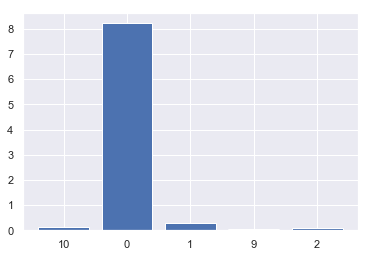

In [33]:
plt.bar(df['Priority'], df['evicted tasks %'], tick_label = df['Priority'])

We see that tasks with lower priority have a higher chance of being evicted, especially those with priority 0, which are significantly more likely to be evicted than those with higher priority.

#### In general, do tasks from the same job run on the same machine?
For this analysis we will use the same table again and only look at job ID, task ID and machine ID. Our idea for this analysis was to count the number of *tasks per job* using the `countByKey()` function where the key is the jobID after mapping, and then also count the number of *different machines per job*. Next, we compare these two values by subtracting the number of machines per job from the number of tasks per job. If these two numbers are equal that means that all tasks of a given job run on different machines. However, if they are different, that means that we have more tasks running on the same machine. We do a sum of these differences and divide it by the total number of tasks. This gives us a percentage of *how often tasks of the same job were running on the same machine.*

In [50]:
task_events_header = ["timestamp", "missing_info", "job_ID", "task_idx", "machine_ID", "event_type", "user", "scheduling_class", "priority", "rrCPU", "rrRAM", "rrLDS", "diff_machine_constraints"]
task_events = sc.textFile("clusterdata-2011-2/task_events/part-00000-of-00500.csv.gz").map(lambda line: line.split(','))

job_ID_idx = findCol(task_events_header, "job_ID")
machine_ID_idx = findCol(task_events_header, "machine_ID")
task_idx = findCol(task_events_header, "task_idx")

#for some tasks, we don't have information about which machine they run on, so we filter those out 
data = task_events.filter(lambda x: x[machine_ID_idx] != '')

tasks_per_job = data.map(lambda x: (x[job_ID_idx], x[task_idx])).distinct().countByKey()
machines_per_job = data.map(lambda x: (x[job_ID_idx], x[machine_ID_idx])).distinct().countByKey()

task_machine_difference = np.sum(np.subtract(list(tasks_per_job.values()), list(machines_per_job.values())))
total_tasks = np.sum(list(tasks_per_job.values()))

print("Tasks of the same job run on the same machine ", round(task_machine_difference/total_tasks*100, 3), "% of the time.")

Tasks of the same job run on the same machine  6.801 % of the time.


We see here that tasks of the same job generally **do not** run on the same machine in a Google cluster.

#### Are there tasks that consume signiﬁcantly less resources than what they requested? 

For this analysis we are going to use the **Task events** table again and also the **Task usage** table, which has the following fields:

   1. start time of the measurement period
   2. end time of the measurement period
   3. job ID
   4. task index
   5. machine ID
   6. mean CPU usage rate
   7. canonical memory usage
   8. assigned memory usage
   9. unmapped page cache memory usage
   10. total page cache memory usage
   11. maximum memory usage
   12. mean disk I/O time
   13. mean local disk space used
   14. maximum CPU usage
   15. maximum disk IO time
   16. cycles per instruction (CPI)
   17. memory accesses per instruction (MAI)
   18. sample portion
   19. aggregation type
   20. sampled CPU usage    
   
From the **Task events** table we extracted the information about the requested CPU and memory for each task into separate RDDs.
Since there can be multiple different values due to several measurements, we only consider the maximum value for each task.

In [57]:
task_events_header = ["timestamp", "missing_info", "job_ID", "task_idx", "machine_ID", "event_type", "user", "scheduling_class", "priority", "rrCPU", "rrRAM", "rrLDS", "diff_machine_constraints"]
task_events = sc.textFile("clusterdata-2011-2/task_events/part-00000-of-00500.csv.gz").map(lambda line: line.split(','))

job_ID_idx = findCol(task_events_header, "job_ID")
task_idx = findCol(task_events_header, "task_idx")
req_cpu_idx = findCol(task_events_header, "rrCPU")
req_mem_idx = findCol(task_events_header, "rrRAM")

requested_cpu = task_events.map(lambda x: ((x[job_ID_idx], x[task_idx]), x[req_cpu_idx])).groupByKey().mapValues(max)
requested_mem = task_events.map(lambda x: ((x[job_ID_idx], x[task_idx]), x[req_mem_idx])).groupByKey().mapValues(max)


From the **Task usage** table we extracted information about the usage of CPU and memory for each task in a similar manner. Since these value was measured several times for each task (indicated by start and end event time fields), we would get a list for each task, so we again look for the maximum value.

In [58]:
task_usage_header = ["start_time", "end_time", "job_ID", "task_idx", "machine_ID", "mean_cpu", "canonical_memory", "assigned_memory", "unmapped_page_cache", "total_page_cache", "maximum_memory", "mean_disk_io", "mean_local_disk", "max_cpu", "max_disk_io", "CPI", "MAI", "sample_portion", "aggregation_type", "sampled_cpu_usage"]
task_usage = sc.textFile("clusterdata-2011-2/task_usage/part-00000-of-00500.csv.gz").map(lambda line: line.split(','))

max_mem_idx = findCol(task_usage_header, "maximum_memory")
max_cpu_idx = findCol(task_usage_header, "max_cpu")
mean_lds_idx = findCol(task_usage_header, "mean_local_disk")

#taking only the maximum value of each resource for each task
tasks_max_mem = task_usage.map(lambda x: ((x[2], x[3]), (x[max_mem_idx]))).groupByKey().mapValues(max)
tasks_max_cpu = task_usage.map(lambda x: ((x[2], x[3]), (x[max_cpu_idx]))).groupByKey().mapValues(max)


Next, we use `join()` to create a single RDD which will contain information about both requested and used CPU. We also use the `map()` function to give us the difference between these two values.

In [71]:
cpu_data = requested_cpu.join(tasks_max_cpu)
cpu_data = cpu_data.map(lambda x: ((x[0][0], x[0][1]), x[1][0], x[1][1], float(x[1][0])-float(x[1][1])))
cpu_data.take(5)

[(('3418309', '0'), '0.125', '0.07849', 0.046509999999999996),
 (('3418309', '1'), '0.125', '0.04156', 0.08344),
 (('3418314', '0'), '0.125', '0.03302', 0.09198),
 (('3418314', '1'), '0.125', '0.03491', 0.09009),
 (('3418319', '0'), '0.03125', '0.02875', 0.0024999999999999988)]

We do the same thing for requested and used memory.

In [81]:
mem_data = requested_mem.join(tasks_max_mem)
mem_data = mem_data.map(lambda x: ((x[0][0], x[0][1]), x[1][0], x[1][1], float(x[1][0])-float(x[1][1])))
mem_data.take(5)

[(('3418309', '0'), '0.07446', '0.06787', 0.006589999999999999),
 (('3418309', '1'), '0.07446', '0.06787', 0.006589999999999999),
 (('3418314', '0'), '0.09473', '0.08044', 0.014289999999999997),
 (('3418314', '1'), '0.09473', '0.08044', 0.014289999999999997),
 (('3418319', '0'), '0.08691', '0.07715', 0.009760000000000005)]

In [82]:
total_cpu = cpu_data.count()
total_mem = mem_data.count()

In order to compute how many tasks consume less resources than they requested, we needed to set a certain treshold. Depending on this threshold the results we get are different and since these values are normalized and sort of abstract it is hard to tell what is the right threshold to choose. 

Therefore, we ran the analysis with different thresholds (`0.05`, `0.1` and `0.2`) and compared the results we got.

In [83]:
table = []
for i in [0.05, 0.1, 0.2]:
    table.append([i, cpu_data.filter(lambda x: (float(x[3]) > i)).count()/total_cpu*100, mem_data.filter(lambda x: (float(x[3]) > i)).count()/total_mem*100])

np_table = np.array(table)
df = pd.DataFrame(np_table)
df.columns = ["Threshold", "greater than threshold (CPU)", "greater than threshold (memory)"]
df["Threshold"] = df["Threshold"].astype(str)
df["greater than threshold (CPU)"] = df["greater than threshold (CPU)"].astype(float)
df["greater than threshold (memory)"] = df["greater than threshold (memory)"].astype(float)
df.head()

,Threshold,greater than threshold (CPU),greater than threshold (memory)
0,0.05,11.284812,11.313793
1,0.1,2.527490,1.864825
2,0.2,0.287582,0.226833


The numbers we are getting are almost the same for CPU and memory in each case, which is expected. It means that there is a correlation between CPU and memory usage.

<BarContainer object of 3 artists>

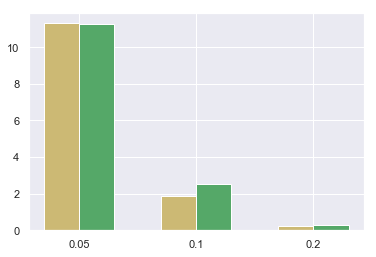

In [78]:
plt.bar(df['Threshold'], df['greater than threshold (CPU)'], label = 'CPU', tick_label = df['Threshold'], width=0.3, align='edge', color='g')
plt.bar(df['Threshold'], df['greater than threshold (memory)'], label = 'Memory', tick_label = df['Threshold'], width=-0.3, align='edge', color='y')

From this graph we can see that if we put `0.05` as the threshold, we get that around 10% of tasks use more resources than they requested. If we increase the threshold to `0.1`, the percentage drops signficantly, to about 2% of tasks. Finally, we see that only a very small number of tasks - around 0.2% - exceeds the threshold of `0.2`